In [2]:
%matplotlib inline
from skimage import io
import numpy as np
from matplotlib import pylab as plt
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
from skimage import img_as_float, img_as_ubyte
from matplotlib.pyplot import plot
from skimage.filters.edges import convolve
import skimage.morphology as mp
from skimage.filters import frangi, hessian
from skimage.filters.edges import convolve
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.stats.mstats import gmean
import random 
from skimage.measure import moments_central, moments, moments_hu
import pandas as pd
from scipy import stats
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage import img_as_bool
import warnings
from skimage.filters import threshold_local, unsharp_mask
warnings.filterwarnings('ignore')

## Wersja na 3.0

In [520]:
class ImageProcessing:
    def __init__(self, imageName, path = 'Foto', show = False):
        self.imageName = imageName
        self.originalImage = []
        self.show = show

        for img in self.imageName:
            self.originalImage.append(io.imread(path + "/" + img))
        self.changedImage = self.originalImage.copy()
    def loadOriginal(self):
         self.changedImage = self.originalImage.copy()
    def plotHist(self):
        fig = plt.figure(figsize = (5,5))
        for img in self.originalImage:
            ax = fig.add_subplot(111)
            img = img_as_ubyte(img)
            histo, x = np.histogram(img, range(0, 256), density=True)
            ax.plot(histo)
    def hsv(self):
        for i, img in enumerate(self.changedImage):
            img = rgb2hsv(img)
            img[:,:,1] = 1
            img[:,:,2] = img[:,:,2].mean() + img[:,:,2].std()
            img = rgb2gray(hsv2rgb(img))
            self.changedImage[i] = img
            
            if self.show:
                io.imshow(img, cmap='gray')
    def erosion(self, K):
        for i, img in enumerate(self.changedImage):
            self.changedImage[i] = mp.erosion(img, selem=K)
            if self.show:
                io.imshow(self.changedImage[i], cmap='gray')
    def dilation(self):
        for i, img in enumerate(self.changedImage):
            self.changedImage[i] = mp.dilation(img)
            if self.show:
                io.imshow(self.changedImage[i], cmap='gray')
    def __normalize_func(self, img, MAX, MIN):
        changed = (img - MIN) / (MAX - MIN)
        changed[changed[:,:] > 1] = 1
        changed[changed[:,:] < 0] = 0
        return changed  
    def normMean(self):
         for i, img in enumerate(self.changedImage):
            MIN = img.mean() - img.std()
            MAX = img.mean() + img.std()
            self.changedImage[i] = self.__normalize_func(img, MAX, MIN)
            if self.show:
                io.imshow( self.changedImage[i], cmap='gray')
    def normPercentile(self, perc = -1):
        for i, img in enumerate(self.changedImage):
            if perc == -1:
                perc = img.mean() - img.std()
            MIN = np.percentile(img, perc)
            MAX = np.percentile(img, 100-perc)
            self.changedImage[i] = self.__normalize_func(img, MAX, MIN)
            if self.show:
                io.imshow( self.changedImage[i], cmap='gray')
    def gamma(self, power = True):
        for i, img in enumerate(self.changedImage):
            if power == True:
                gamma = img.mean() + img.std()
                self.changedImage[i] = img ** gamma
            else:
                img = img ** power
                img[img > 255] = 255
                img[img < 0] = 0
                self.changedImage[i] = img
            if self.show:
                io.imshow( self.changedImage[i], cmap='gray')
    def convolution(self, K):
        K = K / sum(K)
        for i, img in enumerate(self.changedImage):
            self.changedImage[i] = convolve(img, K)
            if self.show:
                io.imshow(self.changedImage[i], cmap='gray')
    def frangiFunc(self):
        for i, img in enumerate(self.changedImage):
            self.changedImage[i] = frangi(img)
            if self.show:
                io.imshow( self.changedImage[i], cmap='gray')
    def binary(self):
        for i, img in enumerate(self.changedImage):
            binary = (img > np.percentile(img, 25)) 
            #binary = threshold_local(img, block_size = 25, method='gaussian')
            binary = np.uint8(binary)
            
            #binary = unsharp_mask(binary, radius=2, amount=4.0)
            #binary = (binary >  np.percentile(binary, 25)) 
            #binary = np.uint8(binary)
            
            
            binary = mp.binary_dilation(binary)
            #binary = mp.binary_erosion(binary, selem = np.ones((4,2)))
            
            K = np.ones((3,1))
            binary = mp.binary_opening(binary,  K)
            binary = mp.binary_erosion(binary,  K)
            binary = mp.binary_erosion(binary,  K)
            
            binary = mp.binary_closing(binary,  K)
        
            binary = 1 - binary
            binary = binary * 255
            
            self.changedImage[i] = binary
            if self.show:
                io.imshow( self.changedImage[i], cmap='gray')

In [521]:
def runAll(obj, AI = False):
    obj.hsv()
    obj.erosion( K = np.array([[ 0, 1, 0],
                                [ 1, 1, 1],
                                [ 0, 1, 0]]))
    obj.normMean()
    obj.normPercentile()
    obj.gamma()
    
    K =  4
    obj.convolution(K = np.ones([K, K]))
    #koniec wstępnego przetwarzania obrazu
    if not AI: 
        obj.frangiFunc()
        obj.normPercentile(perc = 5)
        obj.convolution(K = np.ones([5,1]))
        obj.erosion( K = np.array([[ 0, 1, 0],
                                    [ 1, 1, 1],
                                    [ 0, 1, 0]]))
        obj.dilation()
        
        obj.gamma(-2)
        obj.binary()

In [522]:
def computeScore(changedImage, labeledImage, imageName):
    sens = []
    sp = []
    acc = []
    for binary, original, name in zip(changedImage, labeledImage, imageName):
        print(str(name) + ": \n")
            
        matrix = confusion_matrix(original.ravel(), binary.ravel())
        tn, fp, fn, tp = matrix.ravel()
            
        accu = accuracy_score(original.ravel(), binary.ravel())
        acc.append(accu)
        print("Accuracy score: ")
        print(accu)
        print("\n")
            
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        sens.append(sensitivity)
        sp.append(specificity)
            
        print("Sensitivity: ")
        print(sensitivity)
            
        print("Specificity: ")
        print(specificity)
        print('--------------------')
    print("\n")
    print("Summary: ")
    print("Mean sensitivity: ")
    print(gmean(sens))
            
    print("Mean specificity: ")
    print(gmean(sp))
    print("Mean accuracy: ")
    print(gmean(acc))
    print("Confusion Matrix: ")
    print(matrix)

In [523]:
foto = ['im0001.ppm', 'im0162.ppm', 'im0003.ppm', 'im0236.ppm', 'im0163.ppm']
label = ['im0001.ah.ppm', 'im0162.ah.ppm', 'im0003.ah.ppm', 'im0236.ah.ppm', 'im0163.ah.ppm']

In [524]:
fot = ImageProcessing(foto, show = False)

In [525]:
lab = ImageProcessing(label, path = 'AH', show = False)

In [526]:
runAll(fot, AI = False)

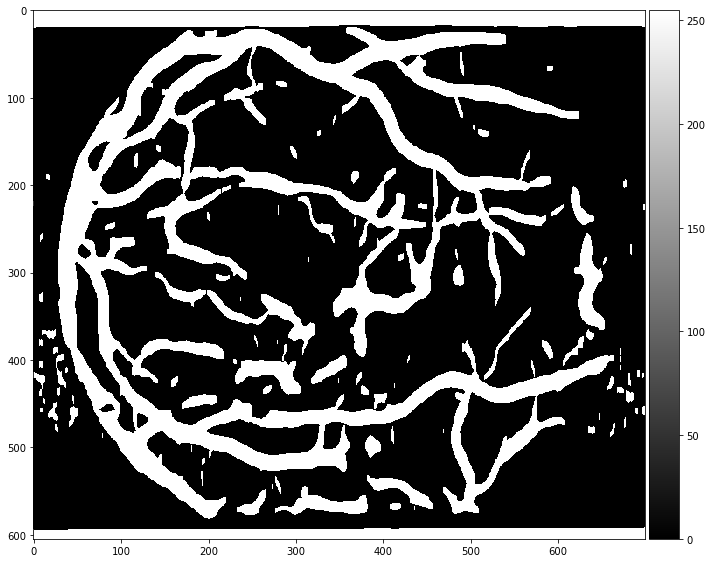

In [527]:
plt.figure(figsize=(10,15))
io.imshow(fot.changedImage[0], cmap = 'gray')

In [528]:
computeScore(fot.changedImage, lab.originalImage, foto)

im0001.ppm: 

Accuracy score: 
0.7902384887839433


Sensitivity: 
0.8621852717536022
Specificity: 
0.7839985014151876
--------------------
im0162.ppm: 

Accuracy score: 
0.7600708382526564


Sensitivity: 
0.6789264413518886
Specificity: 
0.7662971626156819
--------------------
im0003.ppm: 

Accuracy score: 
0.7725171192443919


Sensitivity: 
0.8191359242454133
Specificity: 
0.7695495472868606
--------------------
im0236.ppm: 

Accuracy score: 
0.7681487603305786


Sensitivity: 
0.6641032325338895
Specificity: 
0.7785117100275225
--------------------
im0163.ppm: 

Accuracy score: 
0.7711381345926801


Sensitivity: 
0.7204665506396751
Specificity: 
0.7753852217152187
--------------------


Summary: 
Mean sensitivity: 
0.7449476293805184
Mean specificity: 
0.7747228067577037
Mean accuracy: 
0.77235964645099
Confusion Matrix: 
[[302981  87768]
 [  9155  23596]]


## Wersja na 4.0

In [11]:
images = [f for f in listdir('Foto') if isfile(join('Foto', f))]

In [12]:
labels = [f for f in listdir('AH') if isfile(join('AH', f))]
labels.remove('desktop.ini')

In [13]:
train_setI, test_setI = train_test_split(images, test_size = 0.2, random_state = 42)
train_setI = train_setI[:8]

In [14]:
train_setL, test_setL = train_test_split(labels, test_size = 0.2, random_state = 42)
train_setL = train_setL[:8]

In [15]:
class FeatureExtractor:
    def __init__(self, trainFoto, label = [], cuts = []):
        self.trainFoto = trainFoto
        self.trainFotos = []
        self.cuts = cuts
        self.label = label
        self.features = {}
        random.seed(42)
    def pointExtractor(self, perc = 0.65):
        for i, im in enumerate(self.trainFoto):
            positive = [(y, x) for y in range(2, 602) for x in range(2, 697) if self.label[i][y][x] != 0]
            negative = [(y, x) for y in range(2, 602) for x in range(2, 697) if self.label[i][y][x] == 0]
            X_c = im.shape[1] // 2
            Y_c = im.shape[0] // 2
            cut = []
            
            #samples = int(np.ceil(im.shape[0] * im.shape[1] * perc))
            samples = int(np.ceil(np.sum(self.label[i] != 0) * perc))
            
            big = X_c  if X_c >= Y_c else Y_c

            area = (np.pi * big**2) /  (im.shape[0] * im.shape[1])

            
            pos = random.sample(positive, samples)
            neg = random.sample(negative, samples)
            cut = pos + neg
    
            random.shuffle(cut)
            #for i in range(samples):
            #    y = random.randint(2, im.shape[0]-3)
            #    x = random.randint(2, im.shape[1]-3)
            #    while (y,x) in cut:
            #        y = random.randint(2, im.shape[0]-3)
            #        x = random.randint(2, im.shape[1]-3)
            #    cut.append((y,x))
            #(x**2 + y**2) > (big**2) or 
           
            #for i in range(int(np.ceil((1 - area) * samples))):
            #    y = random.randint(2, im.shape[0]-3)
            #    x = random.randint(2, im.shape[1]-3)
            #    while (x**2 + y**2) <= (big**2) or (y,x) in cut:
            #        y = random.randint(2, im.shape[0]-2)
            #        x = random.randint(2, im.shape[1]-2)
            #    cut.append((y,x))
                      
            random.shuffle(cut)
            self.cuts.append(cut)
            
    def getPixelValues(self):
        centre = []
        for i in range(len(self.trainFoto)):
            for j in range(len(self.cuts[i])):
                centre.append(self.trainFoto[i][self.cuts[i][j][0]][self.cuts[i][j][1]])
        self.features['centre'] = centre
        
    def featureExtractor(self):
        for j, im in enumerate(self.trainFoto):
            self.trainFotos.append([im[self.cuts[j][i][0]-2:self.cuts[j][i][0]+3, self.cuts[j][i][1]-2:self.cuts[j][i][1]+3] 
                                    for i in range(len(self.cuts[j]))])
        variation = []
        central = []
        hu = []
        centre = []
        region = []
        distance = []
        mean = []
        
        for i in range(len(self.trainFotos)):
            
            X_c = self.trainFoto[i].shape[1] // 2
            Y_c = self.trainFoto[i].shape[0] // 2
            R_c = self.trainFoto[i].shape[1] // 3
            for j, image in enumerate(self.trainFotos[i]):
                variation.append(np.var(image))
                M = moments(image)
                #centroid = (M[1, 0] / M[0, 0], M[0, 1] / M[0, 0])
                #central.append(moments_central(image, centroid))
                central.append(stats.moment(image, moment = 2 ,nan_policy = 'omit'))
                hu.append(moments_hu(image))
                centre.append(image[2][2])
                
                if self.cuts[i][j][0] <= R_c or self.cuts[i][j][0] >= R_c*2:
                    region.append(0)
                else:
                    region.append(1)
                
                d = np.sqrt((self.cuts[i][j][1] - X_c)**2 + (self.cuts[i][j][0] - Y_c)**2)
                distance.append(d)
                mean.append(np.mean(image.mean()))
        
            
        self.features['variation'] = variation
        self.features['centralMoments'] = central
        self.features['huMoments'] = hu
        self.features['centre'] = centre
        self.features['region'] = region
        self.features['distance'] = distance
        self.features['mean'] = mean
        

**Train preprocessing**

In [16]:
trainProcessingObj = ImageProcessing(train_setI, show = False)

In [17]:
trainProcessingObjLabel = ImageProcessing(train_setL, path = 'AH', show = False)

**Test preprocessing**

In [18]:
testProcessingObj = ImageProcessing(test_setI, show = False)

In [19]:
testProcessingObjLabel = ImageProcessing(test_setL, path = 'AH', show = False)

---

In [20]:
runAll(trainProcessingObj, AI = True)

In [21]:
runAll(testProcessingObj, AI = True)

**Train Feature Extraction**

In [22]:
trainFeatureObj = FeatureExtractor(trainProcessingObj.changedImage, trainProcessingObjLabel.originalImage)

In [23]:
trainFeatureObj.pointExtractor(perc = 0.70)

In [24]:
trainFeatureObj.featureExtractor()

In [25]:
trainFeatureObjLabel = FeatureExtractor(trainProcessingObjLabel.originalImage, cuts = trainFeatureObj.cuts)

In [26]:
trainFeatureObjLabel.getPixelValues()

In [27]:
trainPD = pd.DataFrame(trainFeatureObj.features)

In [28]:
trainLabelPD = pd.DataFrame(trainFeatureObjLabel.features)

**Test Feature Extraction**

In [29]:
cut = []
for i in range(2, testProcessingObj.changedImage[0].shape[0]-2):
    for j in range(2, testProcessingObj.changedImage[0].shape[1]-2):
        cut.append((i, j))

In [30]:
testFeatureObj = FeatureExtractor(testProcessingObj.changedImage, cuts = [cut] * len(testProcessingObj.changedImage))

In [31]:
testFeatureObj.featureExtractor()

In [32]:
testFeatureObjLabel = FeatureExtractor(testProcessingObjLabel.originalImage, cuts = testFeatureObj.cuts)

In [33]:
testFeatureObjLabel.getPixelValues()

In [34]:
testPD = pd.DataFrame(testFeatureObj.features)

In [35]:
testLabelPD = pd.DataFrame(testFeatureObjLabel.features)

---

In [36]:
def datasetNormalizer(label, datasetPD, parameter):
    datasetPD[label]  = pd.DataFrame(datasetPD[parameter].values.tolist(), index = datasetPD.index)
    datasetPD.drop(parameter, axis = 1, inplace = True)

**Normalize data**

In [37]:
datasetNormalizer(['central1', 'central2', 'central3', 'central4', 'central5'], trainPD, 'centralMoments')
datasetNormalizer(['hu1', 'hu2', 'hu3', 'hu4', 'hu5', 'hu6', 'hu7'], trainPD, 'huMoments')

In [38]:
datasetNormalizer(['central1', 'central2', 'central3', 'central4', 'central5'], testPD, 'centralMoments')
datasetNormalizer(['hu1', 'hu2', 'hu3', 'hu4', 'hu5', 'hu6', 'hu7'], testPD, 'huMoments')

In [39]:
pd.DataFrame(trainPD).head(10)

,variation,centre,region,distance,mean,central1,central2,central3,central4,central5,hu1,hu2,hu3,hu4,hu5,hu6,hu7
0,0.000297,2.381246,0,279.708777,2.363946,0.000516,0.000408,0.000400,0.000075,0.000049,4.713985,22.319411,45.343445,45.058523,2036.676873,212.866084,-3.262036
1,0.000000,0.000000,0,306.819165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.038627,2.724727,0,272.611445,2.655240,0.005707,0.010885,0.022294,0.043960,0.064141,5.221030,29.049733,61.276746,54.870561,3181.641966,295.740267,16.214262
3,0.009112,2.186250,0,317.238081,2.211297,0.000657,0.002621,0.005247,0.008028,0.009361,4.210886,17.947145,36.584334,36.336691,1324.795989,153.935109,-11.595307
4,0.375666,0.590357,1,279.692688,0.717842,0.065205,0.081266,0.062564,0.020452,0.000866,2.623043,7.817272,9.730517,7.603418,65.376050,21.199426,1.789373
5,0.750716,3.629336,0,410.358380,2.870096,0.476067,0.452510,0.485361,0.609163,0.933010,4.343374,22.817487,90.219788,57.641328,4153.173805,273.331119,171.918637
6,0.018425,2.750381,0,127.015747,2.867843,0.020336,0.017563,0.014868,0.015606,0.023244,5.614158,29.893900,57.020955,62.854988,3762.822783,343.478064,29.227825
7,0.002747,3.410029,1,115.433964,3.385933,0.002320,0.002062,0.001037,0.000329,0.000303,6.857995,47.791445,95.332718,92.724640,8717.326274,640.995236,103.184987
8,0.000000,0.000000,0,401.109711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.020417,2.674237,0,252.071418,2.649011,0.021634,0.011811,0.006015,0.002169,0.000602,5.040213,25.030797,53.627330,54.745814,2966.322830,273.894934,6.543411


In [40]:
testPD.head(3)

,variation,centre,region,distance,mean,central1,central2,central3,central4,central5,hu1,hu2,hu3,hu4,hu5,hu6,hu7
0,0.0,0.0,0,459.460553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0,458.703608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0,457.947595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
trainLabelPD.head(3)

,centre
0,0
1,0
2,0


In [42]:
testLabelPD.head(3)

,centre
0,0
1,0
2,0


**Save Data**

In [43]:
trainPD.to_csv('trainFeatures5.csv', index = False)
trainLabelPD.to_csv('trainlabelFeatures5.csv', index = False)
testPD.to_csv('testFeatures5.csv', index = False)
testLabelPD.to_csv('testlabelFeatures5.csv', index = False)

---

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib

## Postprocessing

In [329]:
def postprocessing(final_prediction):
    returned = []
    for i in range(4):
        a = 700 - 4
        b = 605 - 4
        K= np.ones((3,1))
        fragment = final_prediction[a*b*i:(i+1)*a*b]
        
        #K = np.array([[ 0, 1, 0],
        #                        [ 1, 1, 1],
        #                        [ 0, 1, 0]])
        
        fragment = np.array(fragment.reshape(-1,696))
        fragment = mp.binary_opening(fragment,  K)
        fragment = mp.binary_erosion(fragment,  K)
        fragment = mp.binary_closing(fragment,  K)
        #fragment = mp.binary_erosion(fragment,  K)
        fragment = (fragment)*255
        returned = returned + list(fragment.ravel())
    return returned

---

## Model KNN

---

In [ ]:
from sklearn.externals import joblib
neigh_dump = joblib.load('KNNmodel.pkl')
forest_dump = joblib.load('ForsetModel.pkl')

trainPD = pd.read_csv('trainFeatures2.csv')
trainLabelPD = pd.read_csv('trainlabelFeatures2.csv')
testPD = pd.read_csv('testFeatures2.csv')
testLabelPD = pd.read_csv('testlabelFeatures2.csv')

In [332]:
neigh_dump = joblib.load('KNNmodel2.pkl')

In [7]:
testPD.shape

(1673184, 17)

---

In [46]:
imputer = SimpleImputer(strategy = 'most_frequent')

In [47]:
trainPDm = imputer.fit_transform(trainPD)

---

In [ ]:
param_grid = [{'n_neighbors' : [2,3,5]}]

In [ ]:
gridSearch = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5)

In [ ]:
grid_search = gridSearch.fit(trainPDm, np.array(trainLabelPD).ravel())

In [ ]:
grid_search.best_params_

In [ ]:
neigh = grid_search.best_estimator_

In [ ]:
grid_search.best_score_

---

In [48]:
neigh_dump = KNeighborsClassifier(n_neighbors = 3)

In [49]:
valScoreN = cross_val_score(neigh_dump, trainPDm, np.array(trainLabelPD).ravel(), cv = 3)
print(valScoreN)

[0.70273181 0.7135278  0.7216371 ]


In [50]:
neigh_dump.fit(trainPDm, np.array(trainLabelPD).ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [51]:
joblib.dump(neigh_dump, 'KNNmodel2.pkl')

['KNNmodel3.pkl']

---

In [52]:
testPDm = imputer.transform(testPD)

In [84]:
final_prediction = neigh_dump.predict(testPDm)

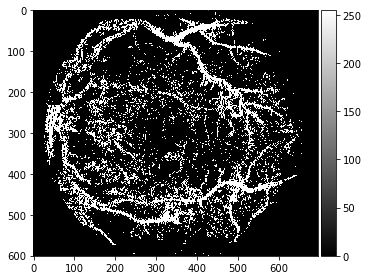

In [318]:
final = postprocessing(final_prediction)

In [325]:
accuracy = accuracy_score(np.array(testLabelPD), final)

In [326]:
matrix = confusion_matrix(np.array(testLabelPD), final)
tn, fp, fn, tp = matrix.ravel()

In [327]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
            
print("Sensitivity: ")
print(sensitivity)
            
print("Specificity: ")
print(specificity)

print(matrix)

Sensitivity: 
0.6130659613942289
Specificity: 
0.8303027638199078
[[1284079  262440]
 [  49011   77654]]


In [328]:
accuracy

0.8138572924436285

---

## Na 5.0

In [56]:
imputer = SimpleImputer(strategy = 'most_frequent')

In [57]:
trainPDm = imputer.fit_transform(trainPD)

---

In [ ]:
param_grid_Forest = [{'n_estimators' : [30,60,100], 'min_samples_split' : [2,3,5]},
             {'bootstrap':[False], 'n_estimators' : [30,60,100], 'min_samples_split' : [2,3,5]}]

In [ ]:
gridSearchForest=RandomizedSearchCV(RandomForestClassifier(),param_grid_Forest,cv=5,n_iter=48)

In [ ]:
gridSearchForest.fit(trainPDm, np.array(trainLabelPD).ravel())
joblib.dump(gridSearchForest.best_estimator_, 'ForestModel.pkl')

In [ ]:
gridSearchForest.best_params_

In [ ]:
forest = gridSearchForest.best_estimator_

In [ ]:
gridSearchForest.best_score_

---

In [59]:
forest_dump = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 2)

In [60]:
valScoreF = cross_val_score(forest_dump, trainPDm, np.array(trainLabelPD).ravel(), cv = 3)
print(valScoreF)

[0.83733413 0.83239664 0.86116852]


In [61]:
forest_dump.fit(trainPDm, np.array(trainLabelPD).ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
joblib.dump(forest_dump, 'ForsetModel2.pkl')

['ForsetModel3.pkl']

---

In [61]:
testPDm = imputer.transform(testPD)

In [91]:
final_predictionForest = forest_dump.predict(testPDm)

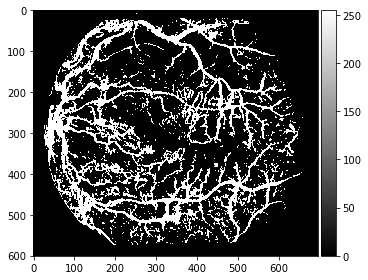

In [333]:
finalF = postprocessing(final_predictionForest)

In [334]:
accuracy = accuracy_score(np.array(testLabelPD), finalF)

In [335]:
matrix = confusion_matrix(np.array(testLabelPD), finalF)
tn, fp, fn, tp = matrix.ravel()

In [336]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
            
print("Sensitivity: ")
print(sensitivity)
            
print("Specificity: ")
print(specificity)

print(matrix)

Sensitivity: 
0.8113290964354795
Specificity: 
0.835727204127463
[[1292468  254051]
 [  23898  102767]]


In [337]:
accuracy

0.8338801948859181

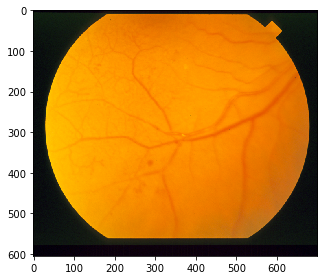

In [6]:
io.imshow(io.imread('Foto/im0324.ppm'))